In [4]:
# https://www.kaggle.com/code/samundersingh/semetic-image

import cv2
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from PIL import Image

In [8]:
train_img_dir = 'D:/KAGGLE/train/train_png'
train_anno_dir = 'D:/KAGGLE/train/train_anno'

# Get path of each image
input_img_paths = sorted([os.path.join(train_img_dir, f"{id}") for id in os.listdir(train_img_dir)])

# Shuffle dataset
random.Random(1337).shuffle(input_img_paths)

batch_size = 4
img_size = 512
threshold = 0.3

In [366]:
# Train - val split
val_num = int(len(input_img_paths)*0.2)
train_img_paths = input_img_paths[:-val_num]
val_img_paths = input_img_paths[-val_num:]

train_gen = HubmapOrgan(batch_size, img_size, train_img_paths)
val_gen = HubmapOrgan(batch_size, img_size, val_img_paths)

In [378]:
train = [1 for i in train_img_paths if '_' not in i.split('\\')[-1]]
val = [1 for i in val_img_paths if '_' not in i.split('\\')[-1]]
sum(val), sum(train)


(80, 271)

In [5]:
def enhance_image(bgr_img):
    lab= cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(12,12))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl,a,b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

In [6]:
def preprocess_image(path, enhance=False):
    image = cv2.imread(path)

    if enhance:
        image = enhance_image(image)

    image = cv2.resize(image, (img_size, img_size))
    # image = Image.fromarray(image, 'RGB')
    # image_array = keras.utils.img_to_array(image)/255
    image_array = image/255
    return image_array

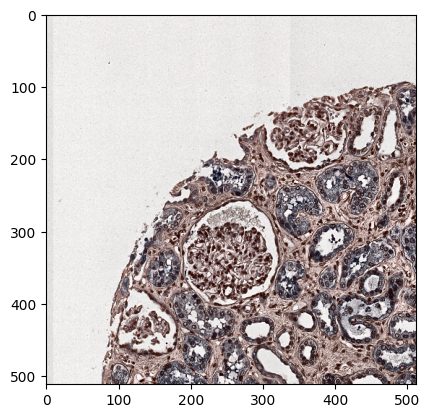

In [32]:
x = np.zeros((30, 512, 512, 3))
p = [r'D:/KAGGLE/train/train_png\2500_1.png', r'D:/KAGGLE/train/train_png\31406_3.png']
pl = []
for j, i in enumerate(p):
    x[j] = preprocess_image(i, enhance=True)
    # pl.append(preprocess_image(i, enhance=True))
plt.imshow(x[0])

In [98]:
class HubmapOrgan(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, shuffle=True, augment=None):
        super().__init__()
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.shuffle = shuffle
        self.augment = augment
       
        
    def __len__(self):
        return math.ceil(len(self.input_img_paths) / self.batch_size)
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_img_paths = self.input_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size, self.img_size, self.img_size, 3))
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1))
        for j, img_path in enumerate(batch_img_paths):
            
            x[j] = preprocess_image(img_path, enhance=True)

            image_id = Path(img_path).stem
            mask_path = os.path.join(train_anno_dir, f'{image_id}.png')
            
            original_mask = keras.utils.load_img(mask_path, color_mode="grayscale")
            # original_mask = cv2.imread(mask_path, 0)
            mask = original_mask.resize((self.img_size, self.img_size))
            mask_array = keras.utils.img_to_array(mask)
            y[j] = mask_array

        if self.augment is None:
            return x.astype('float32'), y.astype('float32')/255
        else:
            aug_x, aug_y = [], []
            for image, mask in zip(x, y):
                transformed = self.augment(image=image, mask=mask)
                aug_x.append(transformed['image'])
                aug_y.append(transformed['mask'])
            return np.array(aug_x), np.array(aug_y)
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.input_img_paths)

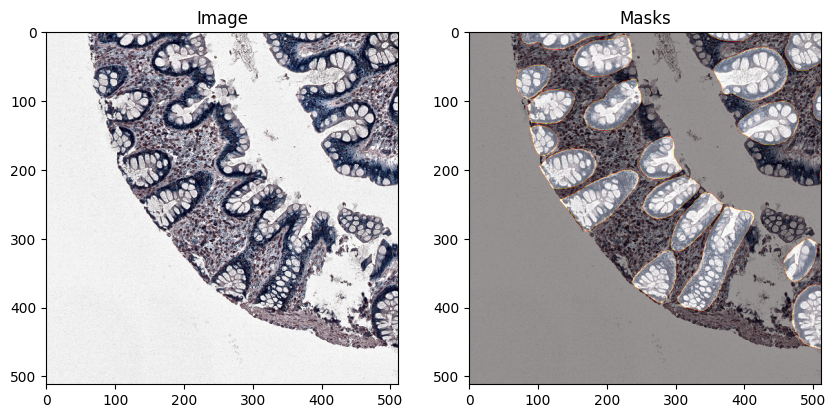

In [99]:
a = HubmapOrgan(30, img_size, input_img_paths, shuffle=False, augment=None)
images, masks = a.__getitem__(0)

rows = 1
cols = 2

plt.figure(figsize=((cols*5, rows*5)))
for i in range(0, rows*cols, 2):
    plt.subplot(rows, cols, i+1)
    plt.title('Image')
    plt.imshow(images[i])

    plt.subplot(rows, cols, i+2)
    plt.title('Masks')
    plt.imshow(images[i])
    plt.imshow(masks[i], cmap='hot', alpha=0.4)

In [69]:
type(images[0].dtype), type(masks[0].dtype)

(numpy.dtype[float32], numpy.dtype[float64])

In [103]:
# Train - val split
val_num = int(len(input_img_paths)*0.2)
train_img_paths = input_img_paths[:-val_num]
val_img_paths = input_img_paths[-val_num:]

train_gen = HubmapOrgan(batch_size, img_size, train_img_paths)
val_gen = HubmapOrgan(batch_size, img_size, val_img_paths)

In [57]:
len(train_img_paths)

351.0

In [104]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
    else:
        next_layer = conv
    skip_connection = conv
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 (3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 (3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv
def unet_model(input_size=(512,512, 3), n_filters=32, n_classes=1):

    inputs = Input(input_size)
    cblock1 = conv_block(inputs,n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0],4*n_filters)
    cblock4 = conv_block(cblock3[0],8*n_filters) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3) 
    cblock6 = conv_block(cblock5[0],32*n_filters,dropout_prob=0.3,max_pooling=False)
    ublock7 = upsampling_block(cblock6[0],cblock5[1],16*n_filters)
    ublock8 = upsampling_block(ublock7,cblock4[1],  8*n_filters)
    ublock9 = upsampling_block(ublock8, cblock3[1],  4*n_filters)
    ublock10 = upsampling_block(ublock9, cblock2[1],  2*n_filters)
    ublock11 = upsampling_block(ublock10, cblock1[1],  n_filters)
    conv12 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock11)

    conv13 = Conv2D(n_classes,1, padding='same',activation='sigmoid')(conv12)
    model = tf.keras.Model(inputs=inputs, outputs=conv13)
    return model

In [105]:
import keras.backend as K
def dice_coeff(y_true, y_pred, smooth=1e-7):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2.0 * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_bce_loss(y_true, y_pred):
    dice = dice_coeff(y_true, y_pred)
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=0)
    dice_bce_loss = dice + bce
    return dice_bce_loss

In [108]:
model = unet_model(input_size=(img_size,img_size,3))
# model.summary()

In [109]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),
             loss=keras.losses.BinaryCrossentropy(),
             metrics='accuracy')

# model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=dice_bce_loss, metrics=[dice_coeff])

In [110]:
model.fit(train_gen, epochs=8, validation_data=val_gen)

Epoch 1/8
  2/351 [..............................] - ETA: 1:06:49 - loss: 0.8341 - accuracy: 0.0921

KeyboardInterrupt: 

In [14]:
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [15]:
test_df = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')
test_ids = test_df['id']
test_dir = '../input/hubmap-organ-segmentation/test_images'

ids = []
rles = []
for id in test_ids:
    path = os.path.join(test_dir, f"{id}.tiff")
    image, original_shape = preprocess_image(path)
    pred = model.predict(np.expand_dims(image, axis=0))
    
    pred_mask = np.where(pred > threshold, 1, 0)[0]

    resized_pred_mask = keras.utils.array_to_img(pred_mask, scale=False).resize((original_shape[0], original_shape[1]), resample=0)

    resized_pred_mask_array = keras.utils.img_to_array(resized_pred_mask, dtype='uint8')
    rle = rle_encode(resized_pred_mask_array)
    ids.append(id)
    rles.append(rle)
    
submission_df = pd.DataFrame({'id':ids,'rle':rles})
submission_df.to_csv('submission.csv', index=False)

In [16]:
submission_df

id                                                rle
0  10078  73216 36 73347 4 75239 36 75370 4 77262 36 773...

------------------------ My Code --------------------------

In [146]:
from tensorflow import keras
model = keras.models.load_model('ver12.h5', compile=False)

1/1 [==============================] - 1s 891ms/step


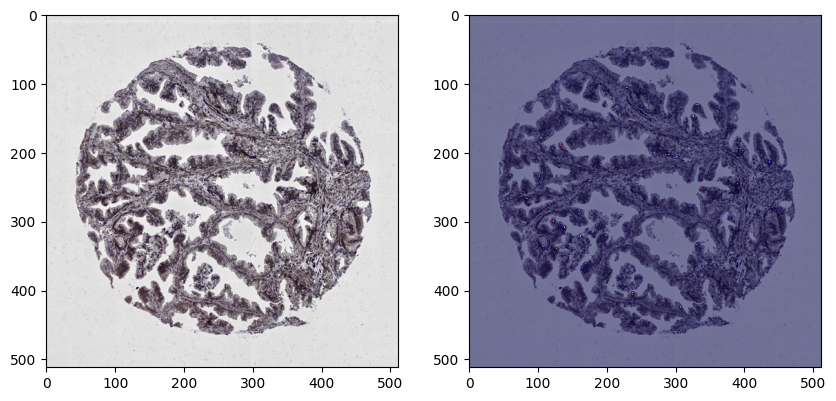

In [147]:
# test_df = pd.read_csv('test.csv')
# test_ids = test_df['id']
# test_dir = './test_images'
# ids = []
# rles = []
for id in test_ids:
    # path = os.path.join(test_dir, f"{id}.tiff")
    path = r'D:\KAGGLE\train_images\14407.tiff'
    image, original_shape = preprocess_image(path, enhance=True)
    # image, original_shape = preprocess_image(path)
    pred = model.predict(np.expand_dims(image, axis=0))
    # pred = model.predict(np.array([image]))
    
    pred_mask = np.where(pred > threshold, 1, 0)[0]

    resized_pred_mask = keras.utils.array_to_img(pred_mask, scale=False).resize((original_shape[0], original_shape[1]), resample=0)

    resized_pred_mask_array = keras.utils.img_to_array(resized_pred_mask, dtype='uint8')
    rle = rle_encode(resized_pred_mask_array)
    ids.append(id)
    rles.append(rle)
    
# submission_df = pd.DataFrame({'id':ids,'rle':rles})
# submission_df.to_csv('submission.csv', index=False)
plt.figure(figsize=((10, 10)))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(pred_mask, cmap='seismic', alpha=0.5)

In [87]:
# path = r'D:\KAGGLE\train_images\14407.tiff'
# image, original_shape = preprocess_image(path)
# np.expand_dims(image, axis=0).shape, np.array([image]).shape
# pred = model.predict(np.expand_dims(image, axis=0))
# pred_mask = np.where(pred > threshold, 1, 0)[0]
plt.figure(figsize=((10, 10)))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(pred_mask, cmap='seismic', alpha=0.5)

((1, 512, 512, 3), (1, 512, 512, 3))

In [71]:
# pred.shape
pred_mask.shape

(512, 512, 1)

In [ ]:
a = HubmapOrgan(30, img_size, input_img_paths, shuffle=False, augment=None)
images, masks = a.__getitem__(0)

rows = 5
cols = 2

plt.figure(figsize=((cols*5, rows*5)))
for i in range(0, rows*cols, 2):
    plt.subplot(rows, cols, i+1)
    plt.title('Predict')

    pred = model.predict(np.expand_dims(images[i], axis=0))
    pred_mask = np.where(pred > threshold, 1, 0)[0]

    plt.imshow(images[i])
    plt.imshow(pred_mask, cmap='hot', alpha=0.4)

    plt.subplot(rows, cols, i+2)
    plt.title('Ground truth')
    plt.imshow(images[i])
    plt.imshow(masks[i], cmap='hot', alpha=0.4)

1/1 [==============================] - 1s 565ms/step


Text(0.5, 1.0, 'Predicted')

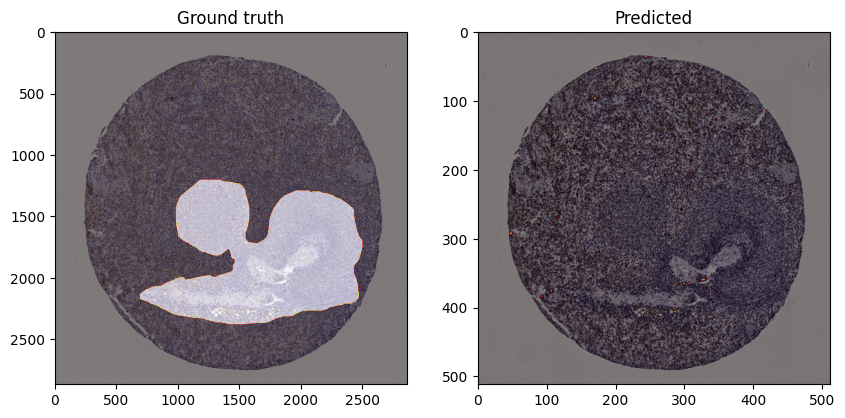

In [150]:
def rle2mask(mask_rle, shape=(1600,256)): # decoder
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

id_ = 11645
path = f'D:/KAGGLE/train_images/{id_}.tiff'
orin_img = tiff.imread(path)

en_image, original_shape = preprocess_image(path, enhance=True)
# image, original_shape = preprocess_image(path)

pred = model.predict(np.expand_dims(en_image, axis=0))
pred_mask = np.where(pred > threshold, 1, 0)[0]

mask = rle2mask(train_df[train_df["id"]==id_]["rle"].values[0], (orin_img.shape[1], orin_img.shape[0]))

plt.figure(figsize=((10, 10)))

plt.subplot(1, 2, 1)
plt.imshow(orin_img)
plt.imshow(mask, cmap='hot', alpha=0.5)
plt.title('Ground truth')

plt.subplot(1, 2, 2)
plt.imshow(en_image)
plt.imshow(pred_mask, cmap='hot', alpha=0.5)
plt.title('Predicted')

In [142]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

1/1 [==============================] - 1s 629ms/step


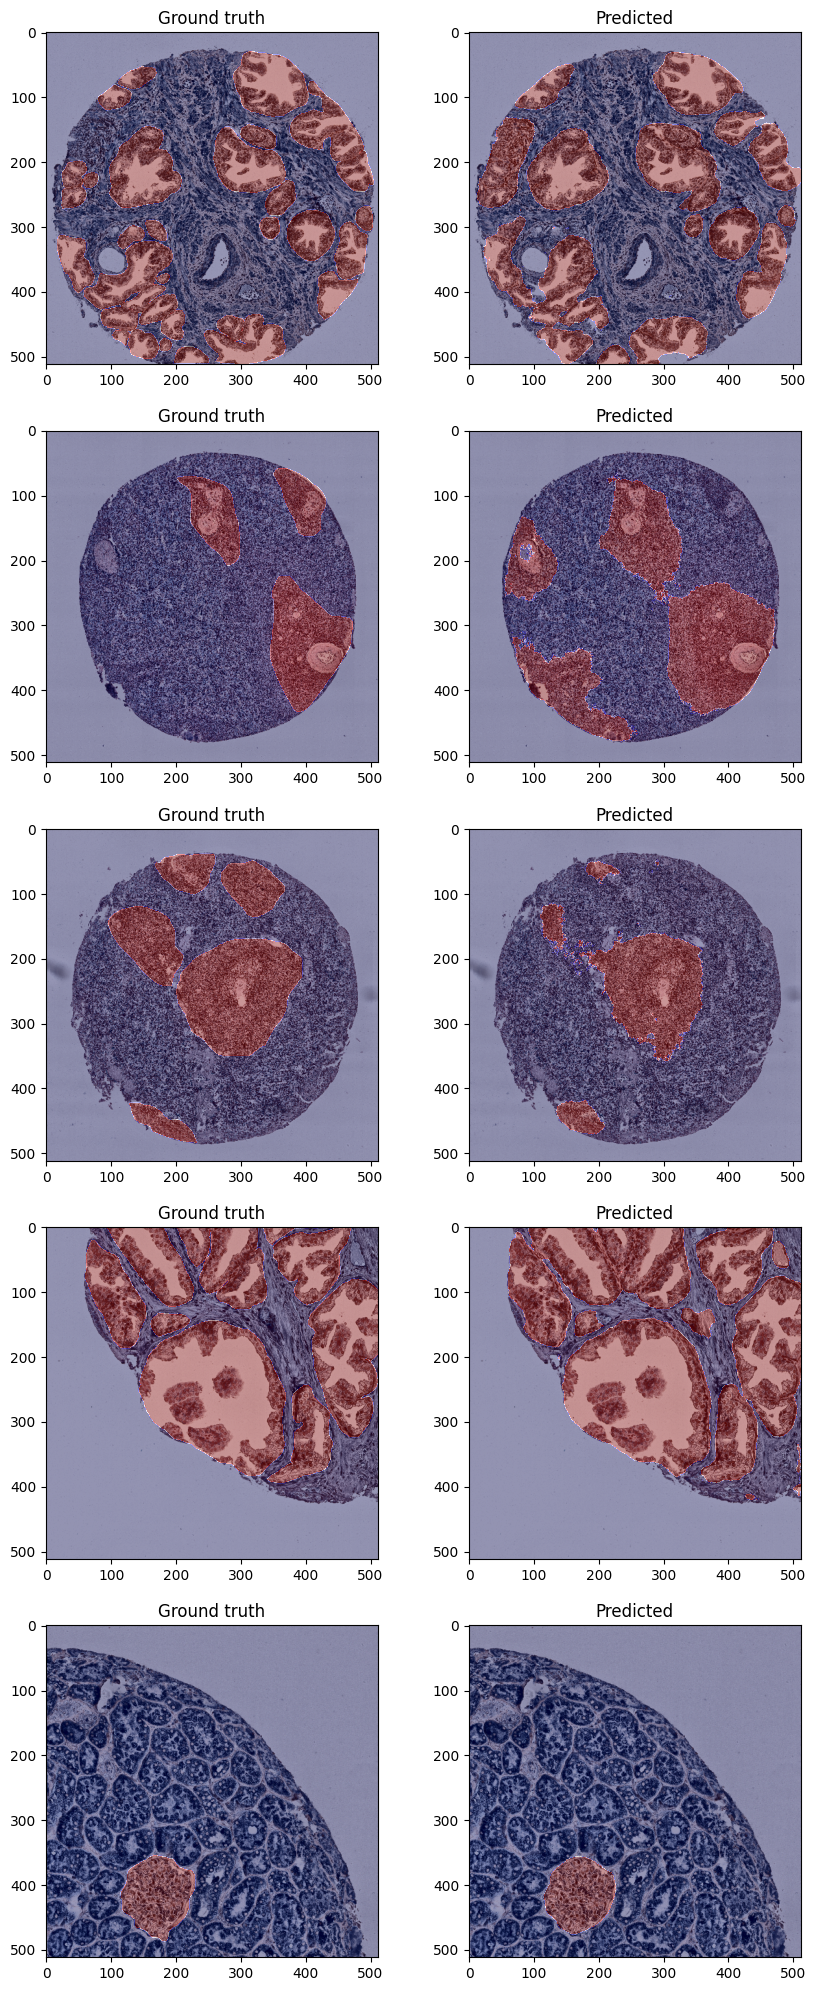

In [9]:
model = keras.models.load_model('ver26.h5', compile=False)

ids = ['1229', '2079', '3054', '8227_3', '9445_2']

rows = 5
cols = 2
plt.figure(figsize=((cols*5, rows*5)))

for i in range(0, rows*cols, 2):

    path = f'D:/KAGGLE/train/train_png/{ids[int(i/2)]}.png'
    mask = f'D:/KAGGLE/train/train_anno/{ids[int(i/2)]}.png'

    mask = cv2.imread(mask, 0)
    mask = cv2.resize(mask, (512, 512))
    image = preprocess_image(path, enhance=True)
    pred = model.predict(np.expand_dims(image, axis=0))
    pred_mask = np.where(pred > 0.6, 1, 0)[0]

    plt.subplot(rows, cols, i+1)
    plt.title('Ground truth')
    plt.imshow(image)
    plt.imshow(mask, cmap='seismic', alpha=0.4)

    plt.subplot(rows, cols, i+2)
    plt.title('Predicted')
    plt.imshow(image)
    plt.imshow(pred_mask, cmap='seismic', alpha=0.4)


1/1 [==============================] - 1s 967ms/step


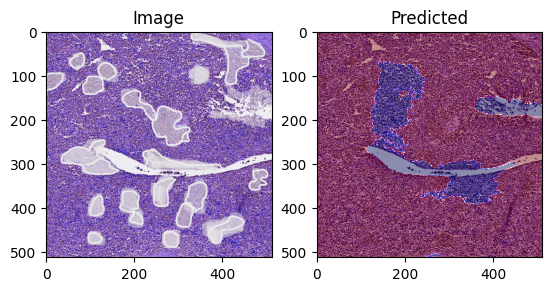

In [487]:
from tensorflow import keras
model = keras.models.load_model('ver32.h5', compile=False)

path = f'D:/KAGGLE/test_images/10078.png' 
mask = f'D:/KAGGLE/test_images/me.png'

mask = cv2.imread(mask)
mask = cv2.resize(mask, (512, 512))

image = preprocess_image(path, enhance=True)
pred = model.predict(np.expand_dims(image, axis=0))
pred_mask = np.where(pred > 0.5 , 1, 0)[0]

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(mask)

plt.subplot(1, 2, 2)
plt.title('Predicted')
plt.imshow(image)
plt.imshow(pred_mask, cmap='seismic', alpha=0.4)


1/1 [==============================] - 1s 558ms/step


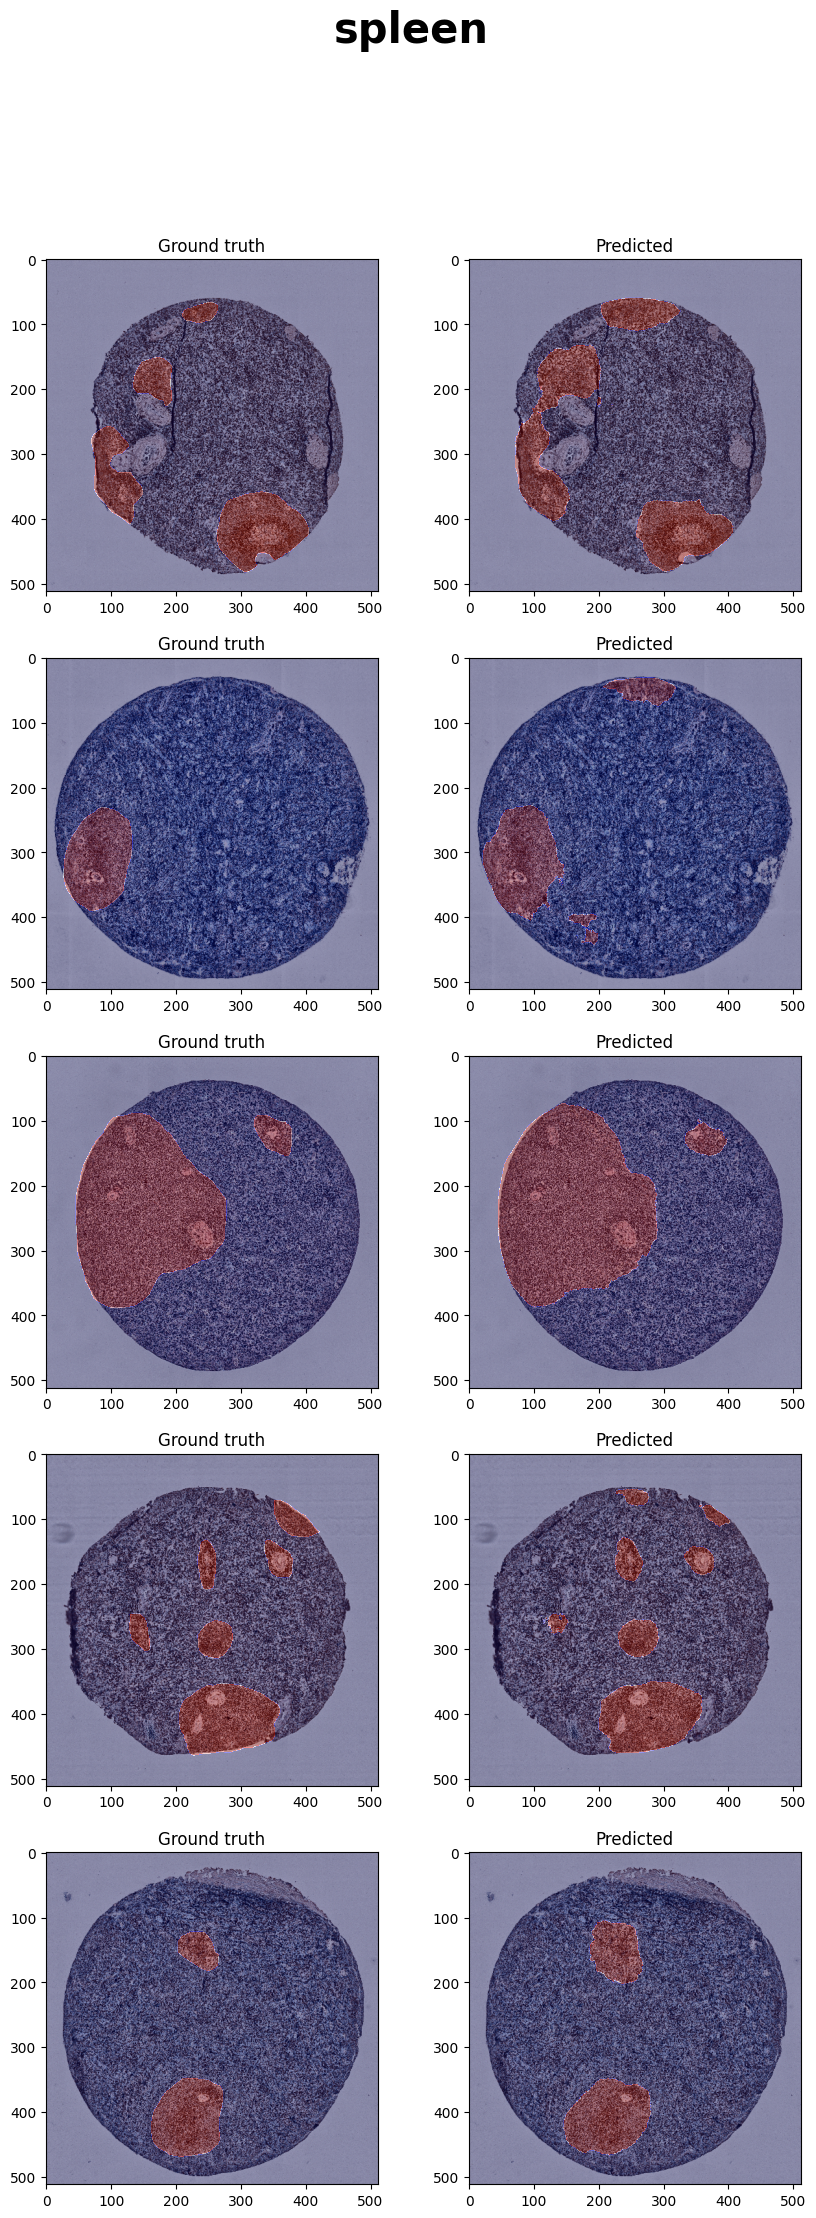

In [488]:
def visualize_batch(df, organ, rows, slide):
    cols = 2
    plt.figure(figsize=((cols*5, rows*5)))
    i = 0

    for index, row in df.iterrows():

        if row['organ'] == organ:
            if i > rows-1:
                break
            path = f'./train/train_png/{index}.png'
            mask = f'./train/train_anno/{index}.png'
            mask = cv2.imread(mask, 0)
            mask = cv2.resize(mask, (512, 512))
            image = preprocess_image(path, enhance=True)
            pred = model.predict(np.expand_dims(image, axis=0))
            pred_mask = np.where(pred > 0.5, 1, 0)[0]

            plt.subplot(rows, cols, i*2+1)
            plt.title('Ground truth')
            plt.imshow(image)
            plt.imshow(mask, cmap='seismic', alpha=0.4)

            plt.subplot(rows, cols, i*2+2)
            plt.title('Predicted')
            plt.imshow(image)
            plt.imshow(pred_mask, cmap='seismic', alpha=0.4)

            i+=1

    plt.suptitle(f'{organ}', size=30, weight="bold")

data = pd.read_csv('train.csv')[['id', 'rle','organ']].set_index('id')
visualize_batch(data, 'spleen', 5, (400,2500))

In [449]:
data['lung'].value_counts()

organ
kidney            99
prostate          93
largeintestine    58
spleen            53
lung              48
Name: count, dtype: int64